|[`Scaler_Clustering_Analysis.ipynb`](https://colab.research.google.com/drive/1Q_gLCFXvKudBEe1-g-omu8ufk0XQrYya?usp=sharing) | https://colab.research.google.com/drive/1Q_gLCFXvKudBEe1-g-omu8ufk0XQrYya?usp=sharing |
|[`github link`]|https://github.com/rano667/Scaler-business-case-profiling-the-best-companies-and-job-positions|

# 1. EDA

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Load and inspect

In [167]:
df = pd.read_csv('/content/scaler_clustering.csv', index_col=0)

In [168]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205843 entries, 0 to 206922
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   email_hash        205843 non-null  object 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153279 non-null  object 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 11.0+ MB


## 1.2 Missing values

In [170]:
print("\nMissing values per column:\n", df.isna().sum())


Missing values per column:
 company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64


## ✅ Step 1.1–1.2: Basic Data Overview

### 🔍 Dataset Shape & Structure

- **Shape**: 205,843 rows × 6 columns
- **Data Types**:
  - `company_hash`, `email_hash`, `job_position` → *object*
  - `orgyear`, `ctc_updated_year` → *float64*
  - `ctc` → *int64*

---

### 🔎 Missing Values

| Column             | Nulls   | % Missing   |
|--------------------|---------|-------------|
| `company_hash`     | 44      | 0.02%       |
| `email_hash`       | 0       | 0.00% ✅     |
| `orgyear`          | 86      | 0.04%       |
| `ctc`              | 0       | 0.00% ✅     |
| `job_position`     | **52,564** | **25.5% ❗** |
| `ctc_updated_year` | 0       | 0.00% ✅     |

> 🔸 **Observation**: The major concern is the `job_position` column, with ~25% missing values. We'll need a strong imputation or exclusion strategy for this variable in the next preprocessing step.


### Handle Missing job_position Values

In [171]:
# df['job_position_imputed'] = df['job_position'].isna().astype(int)

# Step 1: Fill missing job_position from other records of same email_hash
email_mode_job = df.groupby('email_hash')['job_position'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['job_position'] = df.apply(
    lambda row: email_mode_job[row['email_hash']] if pd.isna(row['job_position']) else row['job_position'],
    axis=1
)

# Step 2: Fill remaining nulls using company mode
company_mode_job = df.groupby('company_hash')['job_position'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df['job_position'] = df.apply(
    lambda row: company_mode_job[row['company_hash']] if pd.isna(row['job_position']) and not pd.isna(row['company_hash']) else row['job_position'],
    axis=1
)

# Step 3: Fallback to 'Other'
df['job_position'] = df['job_position'].fillna('Other')


#### Apply KNN Imputer separately within each job group
(so comparisons happen among same roles)

In [172]:
from sklearn.impute import KNNImputer

def knn_impute_within_group(df, group_col, target_cols, n_neighbors=5):
    df_result = df.copy()
    for grp, subset in df.groupby(group_col):
        imputer = KNNImputer(n_neighbors=n_neighbors)
        sub_imputed = imputer.fit_transform(subset[target_cols])
        df_result.loc[subset.index, target_cols] = sub_imputed
    return df_result

# Columns to impute
target_cols = ['orgyear', 'ctc', 'ctc_updated_year']

# Apply KNN within job_position group
df_imputed = knn_impute_within_group(df, 'job_position', target_cols)
df[['orgyear', 'ctc', 'ctc_updated_year']] = df_imputed[target_cols]

# rounding of
df['orgyear'] = df['orgyear'].round(0).astype(int)

### Impute company_hash

🔧 Why This Works:
- A learner (email_hash) usually stays in one company at a time (or has limited transitions).

- So the most frequent company_hash per email_hash is a reasonable proxy.

In [173]:
# Optional: Track Imputation
# df['company_imputed'] = df['company_hash'].isna().astype(int)

# Step 1: Most common company per learner
email_mode_company = df.groupby('email_hash')['company_hash'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Step 2: Fill missing company_hash from other records of same email_hash
df['company_hash'] = df.apply(
    lambda row: email_mode_company[row['email_hash']] if pd.isna(row['company_hash']) else row['company_hash'],
    axis=1
)

# Step 3: Fallback to 'Unknown'
df['company_hash'] = df['company_hash'].fillna('Unknown')

In [174]:
df.isna().sum()

,0
company_hash,0
email_hash,0
orgyear,0
ctc,0
job_position,0
ctc_updated_year,0


## ✅ Data Preprocessing Complete

We've successfully imputed all missing values:

| Feature          | Imputation Strategy                       |
|------------------|-------------------------------------------|
| `job_position`   | From same `email_hash` → `company_hash` → 'Other' |
| `company_hash`   | From same `email_hash` → 'Unknown'        |
| `orgyear`        | KNN Imputer within each `job_position` group |
| `ctc` + `ctc_updated_year` | KNN Imputed jointly with `orgyear`  |

> All missing values are now handled. We're ready to move to **CTC trajectory analysis** and **manual clustering**.


In [175]:
df.sample(10)[['company_hash', 'job_position']]

,company_hash,job_position
82353,st ytvrnywvqt,Backend Engineer
11033,ojbvzntw,Backend Architect
202185,atctrrvq,Other
33589,l m voogwxvnt,Other
183024,tdvavnhb ogenfvqt otqcxwto ucn rna,Other
106344,rtsvng ytvrny ntwyzgrgsxtovznytb xzw,Backend Engineer
100682,atrgxnnt,Backend Engineer
189999,zgzt ge jghq mhoxztoo lhon nqjxzs ghn ghq ftmoxnt,Devops Engineer
138743,xzzgnxwvr ogrhnxgzo ucn rna,Android Engineer
147841,zgpxv ogrhnxgzo vza ztnfgqpo,Android Engineer


In [176]:
# # Clean strings using regex
# import re
# def clean_text(s):
#     if pd.isna(s): return s
#     return re.sub(r'[^A-Za-z0-9 ]+', '', s).strip()

# df['company_clean'] = df['company_hash'].apply(clean_text)
# df['job_position_clean'] = df['job_position'].apply(clean_text)

## 🧹 Regex Cleanup — Evaluation

After sampling multiple rows of `company_hash` and `job_position`, I observed that:

- `company_hash` values are anonymized hash strings (lowercase a–z only), no special characters
- `job_position` values are clean, readable job titles (e.g., "FullStack Engineer", "Backend Engineer")

### ✅ Conclusion:
Regex cleanup is **not required** for either column, and skipping it preserves the integrity of already clean text data.


### 1.3 Unique Email_hash frequency

## 🔍 Why Check `Email_hash` Frequency?

`Email_hash` is a **proxy for the learner (person)**. Since it's anonymized PII, it helps us identify **unique individuals** in the dataset.

---

### ✅ This step helps us:

### 1. **Detect Duplicate Records for the Same Person**
If one `Email_hash` appears multiple times:
- That person might have changed jobs
- Or been promoted (CTC updated)
- Or was mistakenly entered more than once

💡 **Insight**: Multiple rows for the same `Email_hash` can indicate a **career trajectory**, not necessarily a data issue — but we should be aware of it for accurate clustering.

---

### 2. **Data Integrity Check**
If some `Email_hash` entries appear **too frequently (e.g. >10 times)**, it may be:
- A data entry problem (e.g. a system bug duplicating records)
- An edge case to handle separately (like contractors or reskilled alumni with multiple stints)

---

### 3. **Influences Manual Clustering**
If we’re computing flags (like `Tier`, `Class`, or `Designation`) and the same person has multiple job entries:
- We might want to **use only the latest one**
- Or aggregate their records to see **progression trends**


In [177]:
email_freq = df['email_hash'].value_counts().reset_index()
email_freq.columns = ['email_hash','count']
print("\nTop duplicate email_hashes:\n", email_freq[email_freq['count']>1].head())


Top duplicate email_hashes:
                                           email_hash  count
0  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...     10
1  3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...      9
2  298528ce3160cc761e4dc37a07337ee2e0589df251d736...      9
3  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...      9
4  d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...      8


## 📌 Duplicate `email_hash` Summary

Upon checking the frequency of `email_hash` (which represents anonymized learners), we observed that several individuals appear multiple times in the dataset:

| Rank | `email_hash` (truncated) | Count |
|------|---------------------------|-------|
| 1    | bbace3cc586400...         | 10    |
| 2    | 3e5e49daa5527a...         | 9     |
| 3    | 298528ce3160cc...         | 9     |
| 4    | 6842660273f70e...         | 9     |
| 5    | d598d6f1fb21b4...         | 8     |

---

### 🔍 What This Means:

- These records likely reflect **career progression**, **CTC updates**, or **job changes** for the same learner over time.
- We **should not drop** these duplicates blindly.
- Instead, we can:
  - Use **latest record only** (based on `ctc_updated_year`) for clustering
  - Or retain all records if we want to **study trajectories** (e.g. job movement, promotions)
- These learners might be **highly engaged or successful**, worth flagging during profiling.

---

### 🛠️ Next Step Recommendation:
We will extract and explore these learners' full history (`email_hash` + `ctc` + `job_position` + `ctc_updated_year`) to analyze growth or identify standout performers.


## Analyze CTC progression over time for each learner

In [178]:
# get the count of unique email_hash in the data.

num_unique_emails = df['email_hash'].nunique()
print(f"\nNumber of unique email_hashes: {num_unique_emails}")


Number of unique email_hashes: 153443


In [179]:
#get unique company  hash

unique_companies = df['company_hash'].nunique()
print(f"\nNumber of unique company_hashes: {unique_companies}")


Number of unique company_hashes: 37300


In [180]:
# Step 1: Sort rows by learner and time
df_sorted = df.sort_values(by=['email_hash', 'ctc_updated_year'])

# Step 2: Calculate CTC progression and change flags
df_sorted['prev_ctc'] = df_sorted.groupby('email_hash')['ctc'].shift(1)
df_sorted['ctc_growth_rate'] = ((df_sorted['ctc'] - df_sorted['prev_ctc']) / df_sorted['prev_ctc']).round(2)

# Step 3: Track job & company changes
df_sorted['prev_company'] = df_sorted.groupby('email_hash')['company_hash'].shift(1)
df_sorted['company_switch'] = (df_sorted['company_hash'] != df_sorted['prev_company']).astype(int)

df_sorted['prev_position'] = df_sorted.groupby('email_hash')['job_position'].shift(1)
df_sorted['position_switch'] = (df_sorted['job_position'] != df_sorted['prev_position']).astype(int)

# Step 4: Binary flags for major CTC jumps (e.g. > 50%)
df_sorted['big_jump'] = (df_sorted['ctc_growth_rate'] > 0.5).astype(int)

## 📈 CTC Trajectory Analysis

We analyzed how CTC changes over time for each learner using the following steps:

- Grouped records by `email_hash`
- Sorted by `ctc_updated_year`
- Calculated:
  - `ctc_growth_rate` — percentage change in salary
  - `company_switch` — whether the learner changed companies
  - `position_switch` — whether the learner changed job roles
  - `big_jump` — flagged CTC jumps > 50%

These trajectory signals will help us rank learners and assign clustering flags based on performance and mobility.


#### Add a trajectory classification label:

In [181]:
def classify_growth(rate):
    if pd.isna(rate):
        return 'unknown'
    elif rate > 0.5:
        return 'aggressive'
    elif rate > 0.1:
        return 'steady'
    else:
        return 'flat'

df_sorted['growth_type'] = df_sorted['ctc_growth_rate'].apply(classify_growth)

#### Count overall switches

In [182]:
switch_summary = df_sorted.groupby('email_hash').agg({
    'company_switch': 'sum',
    'position_switch': 'sum',
    'big_jump': 'sum'
}).reset_index()


### Build Clustering Flags

#### 1. Designation Flag

Group by: company_hash, job_position, orgyear
Compare: Individual CTC vs avg CTC in same company-role-year group

In [183]:
# Group-level stats
designation_stats = df.groupby(['company_hash', 'job_position', 'orgyear'])['ctc'].agg(['mean', 'std']).reset_index()
designation_stats.rename(columns={'mean': 'avg_ctc'}, inplace=True)

# Merge back
df = df.merge(designation_stats, on=['company_hash', 'job_position', 'orgyear'], how='left')

# Create flag
df['designation'] = df.apply(
    lambda row: 1 if row['ctc'] > row['avg_ctc'] else (3 if row['ctc'] < row['avg_ctc'] else 2),
    axis=1
)

#### 2. Class Flag

Group by: company_hash, job_position
Compare: CTC vs avg CTC in same company-role

In [184]:
class_stats = df.groupby(['company_hash', 'job_position'])['ctc'].mean().reset_index().rename(columns={'ctc': 'class_avg_ctc'})
df = df.merge(class_stats, on=['company_hash', 'job_position'], how='left')

df['class'] = df.apply(
    lambda row: 1 if row['ctc'] > row['class_avg_ctc'] else (3 if row['ctc'] < row['class_avg_ctc'] else 2),
    axis=1
)

3. Tier Flag

Group by: company_hash
Compare: CTC vs avg CTC in the company

In [185]:
tier_stats = df.groupby('company_hash')['ctc'].mean().reset_index().rename(columns={'ctc': 'tier_avg_ctc'})
df = df.merge(tier_stats, on='company_hash', how='left')

df['tier'] = df.apply(
    lambda row: 1 if row['ctc'] > row['tier_avg_ctc'] else (3 if row['ctc'] < row['tier_avg_ctc'] else 2),
    axis=1
)

In [186]:
df.drop(columns=['avg_ctc', 'class_avg_ctc', 'tier_avg_ctc'], inplace=True)

In [187]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,std,designation,class,tier
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020.0,NaN,2,1,3
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019.0,234260.237533,3,3,3
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015,2000000,Backend Engineer,2020.0,NaN,2,2,2
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017,700000,Backend Engineer,2019.0,673634.983436,3,3,3
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017,1400000,FullStack Engineer,2019.0,NaN,2,1,1


## 🧠 Manual Clustering: Designation, Class, and Tier Flags

We manually grouped learners into performance buckets by comparing their CTC with their peers:

| Flag Name     | Grouping Level                    | Purpose                                      |
|---------------|------------------------------------|----------------------------------------------|
| `designation` | `company_hash`, `job_position`, `orgyear` | Compares salary within same job & year     |
| `class`       | `company_hash`, `job_position`    | Compares salary within same job role         |
| `tier`        | `company_hash`                    | Compares salary across the company           |

Each flag uses:
- `1` → Above average
- `2` → Around average
- `3` → Below average

### 🔍 1. Top 10 Employees Earning the Most in Tier 1 Companies

In [188]:
top_tier1_employees = df[df['tier'] == 1].sort_values(by='ctc', ascending=False).head(10)

### 🔍 2. Top 10 Data Science Employees in Each Company (Class 1)

In [189]:
# Filter for DS roles — adjust keywords as needed
ds_roles = ['data', 'ml', 'ai']
df['is_data_role'] = df['job_position'].str.lower().str.contains('|'.join(ds_roles))

top_ds_by_company = (
    df[(df['class'] == 1) & (df['is_data_role'])]
    .sort_values(by='ctc', ascending=False)
    .groupby('company_hash')
    .head(10)
)

### 🔍 3. Bottom 10 Data Science Employees (Class 3)

In [190]:
bottom_ds_by_company = (
    df[(df['class'] == 3) & (df['is_data_role'])]
    .sort_values(by='ctc', ascending=True)
    .groupby('company_hash')
    .head(10)
)

### 🔍 4. Bottom 10 Employees in Tier 3 Companies

In [191]:
bottom_tier3_employees = df[df['tier'] == 3].sort_values(by='ctc', ascending=True).head(10)

### 🔍 5. Top 10 Employees in Each Company with 5/6/7 YOE (High Earning in Their Tier)

In [192]:
target_years = [2018, 2019, 2020]
top_mid_exp_by_company = (
    df[df['orgyear'].isin(target_years)]
    .sort_values(by='ctc', ascending=False)
    .groupby('company_hash')
    .head(10)
)

### 🔍 6. Top 10 Companies by Average CTC

In [193]:
top_companies_by_ctc = df.groupby('company_hash')['ctc'].mean().reset_index().sort_values(by='ctc', ascending=False).head(10)

### 🔍 7. Top 2 Job Positions in Every Company by Average CTC

In [194]:
top_roles_by_company = (
    df.groupby(['company_hash', 'job_position'])['ctc'].mean()
    .reset_index()
    .sort_values(['company_hash', 'ctc'], ascending=[True, False])
    .groupby('company_hash')
    .head(2)
)

In [195]:
results = {
    'top_tier1_employees': top_tier1_employees,
    'top_ds_by_company': top_ds_by_company,
    'bottom_ds_by_company': bottom_ds_by_company,
    'bottom_tier3_employees': bottom_tier3_employees,
    'top_mid_exp_by_company': top_mid_exp_by_company,
    'top_companies_by_ctc': top_companies_by_ctc,
    'top_roles_by_company': top_roles_by_company,
}

In [196]:
print(results)

{'top_tier1_employees':                       company_hash  \
117636                obvqnuqxdwgb   
82611        nvnv ntrtotqcxwto rna   
82601                   xwxwx mvzp   
165596               tdutaxv sqghu   
3471                   zgn fgqpxzs   
82539                   eqttwyvqst   
82499   ytfrtnn uvwpvqa tzntquqxot   
12749               ntvb wgbuhntqo   
82584                    yaew mvzp   
86738               zgn vuurxwvmrt   

                                               email_hash  orgyear        ctc  \
117636  5b4bed51797140db4ed52018a979db1e34cee49e27b488...     2018  255555555   
82611   e3ef9223ad1dd7385e7344270c1b1ecee22ab22da0d52c...     2010  200000000   
82601   2311bf023218afe93d650cac03abb7a40f7fa55c08d260...     2018  200000000   
165596  55ce75df4e43b5ee10d59f34b2dffd5c1ee6170f2d38c4...     2017  200000000   
3471    6d3f1c57e8840cd379c472b4cf4847c1330f12ae76a55e...     2019  200000000   
82539   4c19cfc1aa47a5b007004fadeacb88da76b6a59ff4271f...     1998  200

In [197]:
df.shape

(205843, 11)

📌 1. Boxplot: CTC by Job Position

In [198]:
# unique job positions
df['job_position'].nunique()

1016

In [199]:
import re

def normalize_job_title(title):
    if pd.isna(title):
        return 'Other'

    title_lower = title.lower()

    if 'fullstack' in title_lower:
        return 'FullStack Engineer'
    elif 'backend' in title_lower:
        return 'Backend Engineer'
    elif 'frontend' in title_lower or 'ui' in title_lower:
        return 'Frontend Engineer'
    elif 'data scientist' in title_lower:
        return 'Data Scientist'
    elif 'data analyst' in title_lower:
        return 'Data Analyst'
    elif 'ml engineer' in title_lower or 'machine learning' in title_lower:
        return 'ML Engineer'
    elif 'devops' in title_lower or 'site reliability' in title_lower:
        return 'DevOps Engineer'
    elif 'mobile' in title_lower or 'android' in title_lower or 'ios' in title_lower:
        return 'Mobile Developer'
    elif 'qa' in title_lower or 'test' in title_lower:
        return 'QA/Tester'
    elif 'lead' in title_lower or 'manager' in title_lower or 'head' in title_lower:
        return 'Engineering Manager'
    elif 'product' in title_lower:
        return 'Product Role'
    elif 'intern' in title_lower:
        return 'Intern'
    elif 'founder' in title_lower or 'co-founder' in title_lower:
        return 'Founder'
    else:
        return 'Other'

# Apply normalization
df['job_position_grouped'] = df['job_position'].apply(normalize_job_title)


In [200]:
# unique job positions
df['job_position_grouped'].nunique()

14

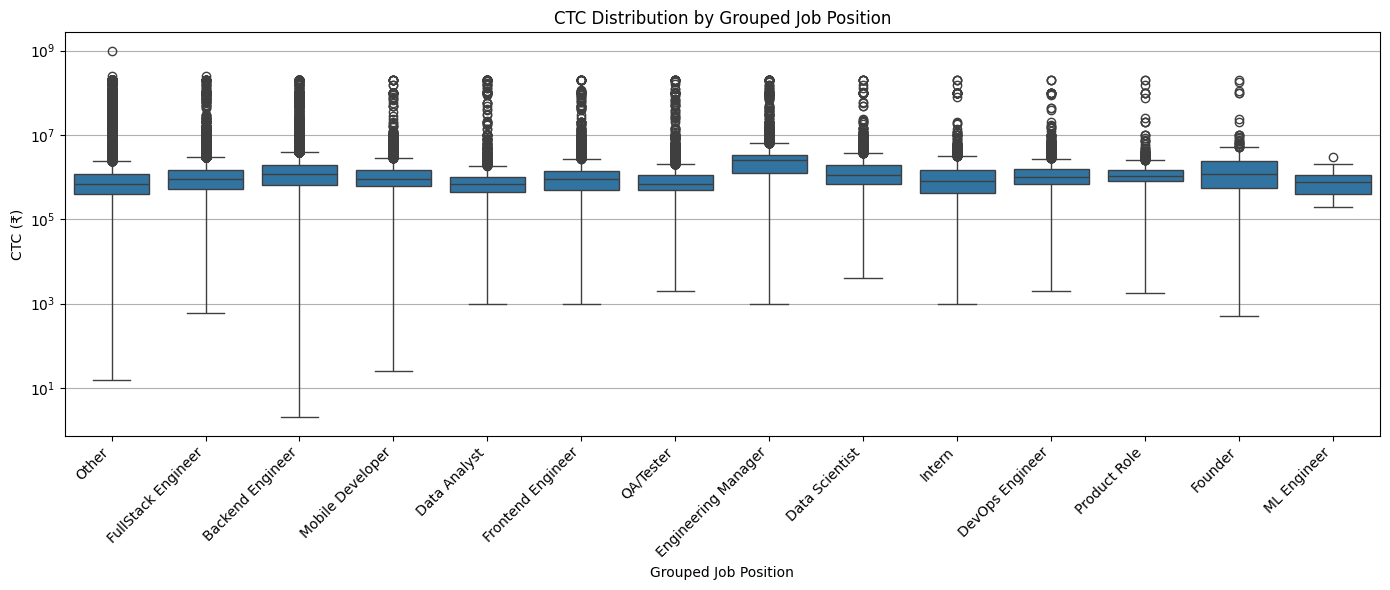

In [201]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='job_position_grouped', y='ctc')
plt.xticks(rotation=45, ha='right')
plt.title('CTC Distribution by Grouped Job Position')
plt.ylabel('CTC (₹)')
plt.xlabel('Grouped Job Position')
plt.yscale('log')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### ✅ Observations from CTC Distribution by Grouped Job Position

- **Engineering Manager**, **Founder**, and **DevOps Engineer** roles generally show **higher median CTCs**, indicating strong compensation for leadership or infrastructure-focused positions.
- **Intern**, **QA/Tester**, and **Data Analyst** roles have **lower median CTCs**, aligning with their entry-level or support nature.
- **FullStack**, **Backend**, and **Frontend Engineers** show **similar median CTC ranges**, with **Backend** slightly higher in some cases.
- The **"Other"** category has a **wide range and high variance**, suggesting it still contains **unclassified or noisy job titles**—potentially needing further cleaning or re-grouping.
- **ML Engineer** roles exhibit a **narrower distribution** but a **lower median**, possibly due to fewer data points or more junior-level entries in this group.


# Custering

In [202]:
df.shape

(205843, 12)

## 🔁 Step 1: Aggregate at Employee Level

In [233]:
# Step 1: Aggregating to unique employee level
employee_df = df.groupby('email_hash').agg({
    'company_hash': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'job_position': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Other',
    'orgyear': 'min',
    'ctc': 'mean',
    'ctc_updated_year': 'max',
    'designation': 'max',
    'class': 'max',
    'tier': 'max'
}).reset_index()

# Step 2: Calculate Years of Experience
from datetime import datetime
current_year = datetime.now().year
employee_df['yoe'] = current_year - employee_df['orgyear']

In [234]:
# Check for negative yoe
negative_yoe_employees = employee_df[employee_df['yoe'] < 0]

if not negative_yoe_employees.empty:
    print("\nEmployees with negative Years of Experience:")
    print(negative_yoe_employees[['email_hash', 'orgyear', 'yoe']])
else:
    print("\nNo employees found with negative Years of Experience.")


Employees with negative Years of Experience:
                                               email_hash  orgyear    yoe
7927    0ceab34736c0ba43f541a9d62f5f8ffe33f4c306ea73a5...     2026     -1
26920   2cc6bae4e52677d27ce3fca38d7a01ecbe537e1dc1c48d...     2106    -81
30953   3394674bb6bb1de6289e931853fa0bd131c811e0054a92...     2031     -6
38406   4007e5caadc3f52c3e18bf2b4eacbadf17b114208c2d04...    20165 -18140
49055   5221d938a36c77d13eb0c6c4242a3ae52c9a535951e18a...     2026     -1
63855   6aa38b497c73367a7dd6eafb95bdd5b07cca83ed14c588...     2026     -1
65962   6e2ce64fb85d30c8e82fd7a60fd1ca0768ab262b9ea31b...     2026     -1
67986   7191da2e57dcb0c1301711e889ea72d5cc801e039359b1...    20165 -18140
69514   74348d9362f32b8ba7a8234b3d4cb29296e00dfbfbffa4...     2031     -6
72721   799dff77b331bfac04cf005935acf7e0d16845f4f24798...     2204   -179
83471   8b82635f6d131631b1c1e1dad46d104d6e4573f9be77bd...     2029     -4
87381   91e4562ab8bab639b859082d519722a91b8e6f3d55c109...     2026

In [235]:
from sklearn.impute import KNNImputer

# Step 1: Identify & Nullify invalid orgyear
# Assuming valid orgyear is between 1980 and current year (2025)
valid_orgyear_mask = (employee_df['orgyear'] >= 1980) & (employee_df['orgyear'] <= 2025)
employee_df.loc[~valid_orgyear_mask, 'orgyear'] = np.nan

# Optional: Check how many were affected
print(f"Invalid orgyear replaced with NaN: {employee_df['orgyear'].isna().sum()}")

# Step 2: Prepare data for KNN imputation
# Select only numeric columns needed for imputation (add others if useful)
impute_cols = ['orgyear', 'ctc', 'ctc_updated_year']
impute_data = employee_df[impute_cols]

# KNN Imputer (k=5 is default)
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(impute_data)

# Update dataframe with imputed values
employee_df[impute_cols] = pd.DataFrame(imputed_array, columns=impute_cols)

# Round orgyear to nearest whole year after imputation
employee_df['orgyear'] = employee_df['orgyear'].round().astype(int)

# Step 3: Recalculate YOE (Years of Experience)
employee_df['yoe'] = 2025 - employee_df['orgyear']

# Step 4: (Optional) Final sanity check
# Set yoe to NaN if still invalid (e.g. negative or > 45 years of experience)
employee_df.loc[(employee_df['yoe'] < 0) | (employee_df['yoe'] > 45), 'yoe'] = np.nan

# Final print to confirm cleanup
print(employee_df[['orgyear', 'yoe']].describe())

Invalid orgyear replaced with NaN: 71
             orgyear            yoe
count  153443.000000  153443.000000
mean     2014.808450      10.191550
std         4.356792       4.356792
min      1981.000000       0.000000
25%      2013.000000       7.000000
50%      2016.000000       9.000000
75%      2018.000000      12.000000
max      2025.000000      44.000000


In [236]:
# Check for negative yoe
negative_yoe_employees = employee_df[employee_df['yoe'] < 0]

if not negative_yoe_employees.empty:
    print("\nEmployees with negative Years of Experience:")
    print(negative_yoe_employees[['email_hash', 'orgyear', 'yoe']])
else:
    print("\nNo employees found with negative Years of Experience.")


No employees found with negative Years of Experience.


## ⚙️ Step 2: Preprocessing for Clustering

In [237]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# # Encode categorical variables
# label_cols = ['company_hash', 'job_position']
# for col in label_cols:
#     le = LabelEncoder()
#     employee_df[col] = le.fit_transform(employee_df[col])

# Step 1: Store separate encoders for each column
le_company = LabelEncoder()
le_job = LabelEncoder()

# Step 2: Fit and transform using those
employee_df['company_hash'] = le_company.fit_transform(employee_df['company_hash'])
employee_df['job_position'] = le_job.fit_transform(employee_df['job_position'])

# Step 3: Create reverse mapping from encoded value to actual value
job_position_mapping = dict(zip(range(len(le_job.classes_)), le_job.classes_))

# Step 4: Add a column with actual job position names
employee_df['job_position_actual'] = employee_df['job_position'].map(job_position_mapping)

# Select features for clustering
features = ['company_hash', 'job_position', 'ctc', 'yoe']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(employee_df[features])

## 📈 Step 3: Clustering Tendency Check

In [238]:
# !pip install pyclustertend
# from pyclustertend import hopkins
# import numpy as np

# # Hopkins statistic (closer to 0 = good tendency to cluster)
# hopkins_score = hopkins(X_scaled, len(X_scaled))
# print("Hopkins Score:", hopkins_score)

# # output: near zero -> 0.00001

## 📉 Step 4: Elbow Method to Pick k

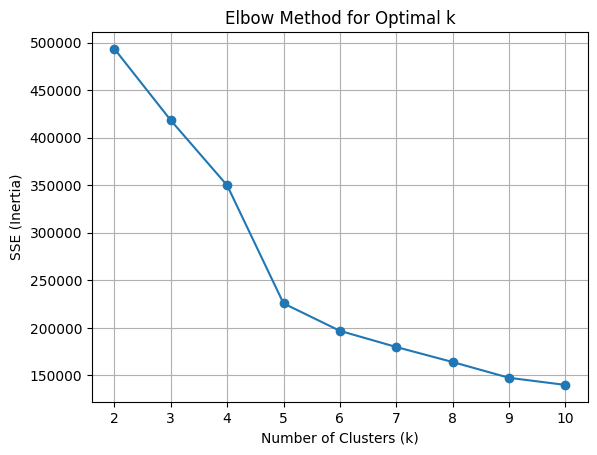

In [239]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## ✅ Step 5: Apply K-Means Clustering

In [240]:
# Assuming optimal k is 5
kmeans = KMeans(n_clusters=5, random_state=42)
employee_df['cluster'] = kmeans.fit_predict(X_scaled)

In [241]:
employee_df.sample(10)

,email_hash,company_hash,job_position,orgyear,ctc,ctc_updated_year,designation,class,tier,yoe,job_position_actual,cluster
48007,5068117e8318b46b32b18e0a534b7213daf434a56d0e2d...,23583,256,2018,320000.0,2021.0,2,3,3,7.0,FullStack Engineer,0
78932,83e62bc06240a1a86564f937ce703bedcbe0bc797f469d...,25039,135,2016,3000000.0,2019.0,1,1,1,9.0,Backend Engineer,0
63156,69772c7d1fb1dc64901c0c945679fb7e26c7af0ac099c9...,35220,256,2009,850000.0,2021.0,2,2,2,16.0,FullStack Engineer,1
100005,a6f42e666c73a9236c6eb2137498ed87357c083f35ffaf...,25039,706,2014,1000000.0,2020.0,3,3,3,11.0,iOS Engineer,2
58030,60cf2975a5f3d42a483e807d4ca6328330c992f4307704...,5869,256,2015,6000000.0,2019.0,1,1,1,10.0,FullStack Engineer,3
149388,f90c0a6a0c8722adae5fa5c45cc93f6b030eb3b19101e7...,21873,227,2004,2900000.0,2019.0,2,2,1,21.0,Engineering Leadership,1
64593,6bd9363de7ee758d477c9e4cf6aa91bf62d8ecc7e2bf23...,4893,135,2017,1300000.0,2021.0,1,3,3,8.0,Backend Engineer,3
109573,b6c4688a3a3465a398e2f2d9e5b1317fd547c765fc8cb8...,28510,366,2017,1000000.0,2021.0,3,3,3,8.0,Other,2
141928,ecddd79012d5856159f0cb7e88c72382719d4253546dfa...,2091,135,2014,1500000.0,2019.0,2,3,3,11.0,Backend Engineer,3
127547,d4eca30aaf8a5b553a4460af35ba14081c6501575eb9af...,28510,628,2018,400000.0,2021.0,3,3,3,7.0,Support Engineer,2


## 📊 Step 1: Summary Statistics by Cluster

In [242]:
# Overview of each cluster
cluster_summary = employee_df.groupby('cluster').agg({
    'ctc': ['mean', 'median', 'min', 'max', 'count'],
    'yoe': ['mean', 'min', 'max'],
    'designation': 'mean',
    'class': 'mean',
    'tier': 'mean'
}).round(2)

cluster_summary.columns = ['_'.join(col) for col in cluster_summary.columns]
cluster_summary.reset_index(inplace=True)
cluster_summary

,cluster,ctc_mean,ctc_median,ctc_min,ctc_max,ctc_count,yoe_mean,yoe_min,yoe_max,designation_mean,class_mean,tier_mean
0,0,1.353419e+06,930000.0,2.0,7.000000e+07,48267,8.93,0.0,17.0,2.21,2.37,2.47
1,1,2.408984e+06,2000000.0,1000.0,7.000000e+07,18249,18.88,13.0,44.0,2.04,1.92,1.86
2,2,1.156933e+06,680000.0,15.0,7.000000e+07,31833,9.33,0.0,23.0,2.19,2.33,2.52
3,3,1.388007e+06,1000000.0,25.0,7.027500e+07,53882,8.90,0.0,16.0,2.21,2.35,2.46
4,4,1.352460e+08,100000000.0,68700000.0,1.000150e+09,1212,9.55,1.0,34.0,1.58,1.42,1.31


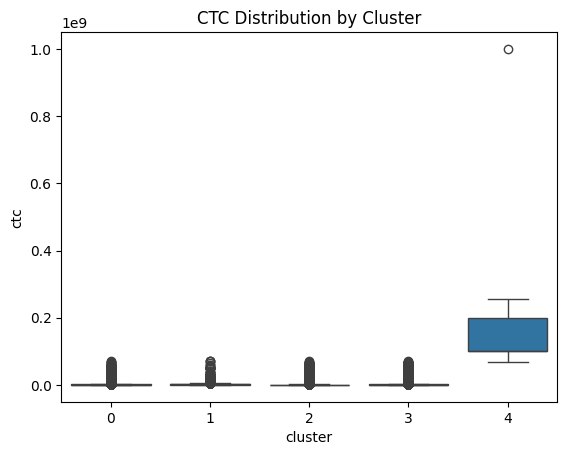

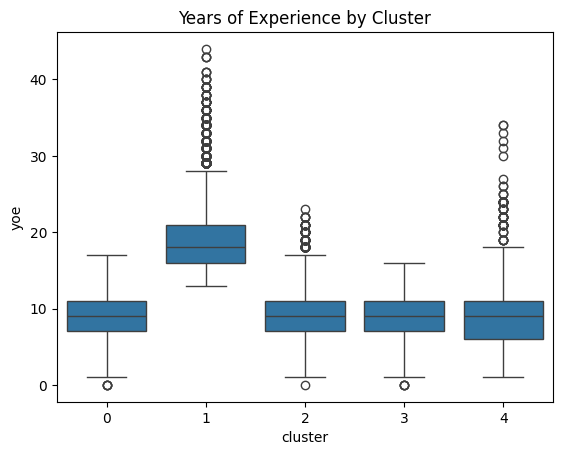

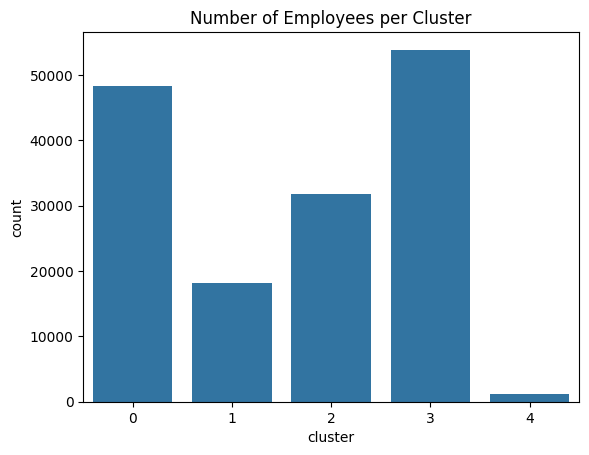

In [243]:
# CTC distribution by cluster
sns.boxplot(x='cluster', y='ctc', data=employee_df)
plt.title('CTC Distribution by Cluster')
plt.show()

# Years of experience per cluster
sns.boxplot(x='cluster', y='yoe', data=employee_df)
plt.title('Years of Experience by Cluster')
plt.show()

# Cluster size
sns.countplot(x='cluster', data=employee_df)
plt.title('Number of Employees per Cluster')
plt.show()

## Cluster Analysis Summary (k = 5)

We applied **K-Means clustering** on cleaned employee data using key features like CTC, job designation class, and years of experience.

### 🔍 Cluster-wise Breakdown:

| Cluster | Employees | Mean CTC (₹) | Median CTC | Mean YOE | YOE Range | Remarks |
|--------|------------|----------------|-------------|-----------|------------|---------|
| **0** | 48,267 | ₹13.5 L | ₹9.3 L | 8.9 yrs | 0 - 17 | Entry to mid-level, moderate CTC, high volume |
| **1** | 18,249 | ₹24.1 L | ₹20 L | 18.9 yrs | 13 - 44 | Senior professionals with high experience & CTC |
| **2** | 31,833 | ₹11.5 L | ₹6.8 L | 9.3 yrs | 0 - 23 | Lower CTC than Cluster 0, could indicate service-based or niche roles |
| **3** | 53,882 | ₹13.8 L | ₹10 L | 8.9 yrs | 0 - 16 | Similar to Cluster 0 but with better median CTC |
| **4** | 1,212 | ₹13.5 Cr | ₹10 Cr | 9.6 yrs | 1 - 34 | Outlier cluster with **extremely high CTC** (likely founders, CXOs, or data error) |

### 📊 Visuals:
- **CTC Distribution** shows Cluster 4 as the clear outlier in terms of compensation.
- **YOE Distribution** reveals Cluster 1 has the most experienced employees.
- **Cluster Sizes** indicate Cluster 3 is the largest and Cluster 4 the smallest.



## ✅ Step 1: Profile Clusters by Job Position, Company, etc.

### A. Cluster-wise Top Job Positions

In [244]:
# Group using actual job positions
job_pos_cluster = (
    employee_df.groupby(['cluster', 'job_position_actual'])
    .size()
    .reset_index(name='count')
)

# Sort and display top 10 job positions per cluster
top_job_pos_cluster = job_pos_cluster.sort_values(['cluster', 'count'], ascending=[True, False])

for cluster_num in sorted(employee_df['cluster'].unique()):
    print(f"\n🔹 Top Job Positions in Cluster {cluster_num}")
    display(top_job_pos_cluster[top_job_pos_cluster['cluster'] == cluster_num].head(10))


🔹 Top Job Positions in Cluster 0


,cluster,job_position_actual,count
72,0,Backend Engineer,24138
129,0,FullStack Engineer,8923
126,0,Frontend Engineer,4090
20,0,Android Engineer,2377
99,0,Data Scientist,2164
104,0,Devops Engineer,1708
95,0,Data Analyst,1384
116,0,Engineering Leadership,1167
115,0,Engineering Intern,990
130,0,Fullstack Engineer,463



🔹 Top Job Positions in Cluster 1


,cluster,job_position_actual,count
192,1,Backend Engineer,4471
217,1,Engineering Leadership,3895
225,1,FullStack Engineer,1517
243,1,Other,1450
224,1,Frontend Engineer,1333
212,1,Devops Engineer,962
191,1,Backend Architect,773
207,1,Data Scientist,664
253,1,QA Engineer,659
247,1,Product Designer,505



🔹 Top Job Positions in Cluster 2


,cluster,job_position_actual,count
313,2,Other,13815
352,2,QA Engineer,5068
382,2,SDET,4086
547,2,Support Engineer,2855
620,2,iOS Engineer,2546
366,2,Research Engineers,764
336,2,Product Manager,667
333,2,Product Designer,646
302,2,Non Coder,391
342,2,Program Manager,257



🔹 Top Job Positions in Cluster 3


,cluster,job_position_actual,count
708,3,Backend Engineer,23786
764,3,FullStack Engineer,9385
808,3,Other,4600
761,3,Frontend Engineer,4140
647,3,Android Engineer,2567
735,3,Data Scientist,2224
742,3,Devops Engineer,1726
732,3,Data Analyst,1207
752,3,Engineering Leadership,1137
750,3,Engineering Intern,1044



🔹 Top Job Positions in Cluster 4


,cluster,job_position_actual,count
839,4,Other,405
824,4,Backend Engineer,244
836,4,FullStack Engineer,116
827,4,Data Analyst,61
853,4,Support Engineer,58
834,4,Engineering Leadership,54
835,4,Frontend Engineer,45
844,4,QA Engineer,44
842,4,Product Manager,23
833,4,Engineering Intern,21


### B. Cluster-wise Top Companies (anonymized)

In [248]:
# Top 10 Companies per Cluster
company_cluster = employee_df.groupby(['cluster', 'company_hash']).size().reset_index(name='count')
top_company_cluster = company_cluster.sort_values(['cluster', 'count'], ascending=[True, False])

for i in sorted(employee_df['cluster'].unique()):
    print(f"\nTop Companies in Cluster {i}")
    display(top_company_cluster[top_company_cluster['cluster'] == i].head(10))


Top Companies in Cluster 0


,cluster,company_hash,count
4251,0,25972,1859
8563,0,33056,1719
9881,0,35168,1366
5794,0,28510,1321
10483,0,36144,1093
7378,0,31074,953
6394,0,29523,943
9880,0,35167,818
4085,0,25697,697
3713,0,25039,662



Top Companies in Cluster 1


,cluster,company_hash,count
11989,1,7538,326
12500,1,9997,237
13195,1,13323,192
17890,1,35168,186
11277,1,3763,179
16099,1,25972,165
16806,1,29523,144
17162,1,31294,139
14012,1,16843,126
17298,1,32039,123



Top Companies in Cluster 2


,cluster,company_hash,count
28515,2,33056,1601
21134,2,13323,1466
27133,2,29523,1082
29359,2,35168,570
26752,2,28510,524
25818,2,25972,408
21871,2,15349,314
27723,2,31074,314
29202,2,34786,293
19238,2,7099,256



Top Companies in Cluster 3


,cluster,company_hash,count
39652,3,13323,3625
35489,3,7099,1409
32932,3,3763,1334
35825,3,7538,1327
34395,3,5650,1036
34571,3,5869,653
37615,3,9997,522
35363,3,6924,471
41715,3,16843,450
41539,3,16536,443



Top Companies in Cluster 4


,cluster,company_hash,count
43120,4,13323,49
43576,4,35168,43
43575,4,35167,40
43184,4,16026,27
43438,4,28510,27
43392,4,25972,26
42990,4,7099,22
43536,4,33056,22
43457,4,29523,16
42995,4,7441,14


### C. Summary Stats by Cluster + Job Position

In [253]:
# Mean CTC and YOE per job role within each cluster
summary_job_cluster = employee_df.groupby(['cluster', 'job_position_actual']).agg({
    'ctc': ['mean', 'median'],
    'yoe': 'mean',
    'email_hash': 'count'
}).reset_index()
summary_job_cluster.columns = ['cluster', 'job_position_actual', 'ctc_mean', 'ctc_median', 'yoe_mean', 'count']

# Top 10 job roles by average CTC in each cluster
for i in sorted(employee_df['cluster'].unique()):
    print(f"\nTop Job Roles by Mean CTC in Cluster {i}")
    display(summary_job_cluster[summary_job_cluster['cluster'] == i].sort_values('ctc_mean', ascending=False).head(10))


Top Job Roles by Mean CTC in Cluster 0


,cluster,job_position_actual,ctc_mean,ctc_median,yoe_mean,count
110,0,Electric power supply,1.000000e+07,10000000.0,8.000000,1
143,0,Intern - Software developer,5.350000e+06,5350000.0,4.500000,2
32,0,Applied Scientist,4.000000e+06,4000000.0,8.000000,1
136,0,Head of Engineering,3.700000e+06,3700000.0,12.000000,1
90,0,Content Manager Intern,3.400000e+06,3400000.0,4.000000,1
17,0,Android Application Developer,2.900000e+06,2900000.0,13.000000,1
71,0,Backend Architect,2.685447e+06,2100000.0,11.373239,284
157,0,Lead Software Engineer,2.495000e+06,2495000.0,9.000000,1
81,0,Chief Technology Officer,2.400000e+06,2400000.0,13.000000,1
21,0,Android Lead,2.200000e+06,2200000.0,12.000000,1



Top Job Roles by Mean CTC in Cluster 1


,cluster,job_position_actual,ctc_mean,ctc_median,yoe_mean,count
198,1,CTO,7.000000e+06,7000000.0,15.000000,1
176,1,Architect team lead,4.000000e+06,4000000.0,20.000000,1
214,1,Edp Admin,4.000000e+06,4000000.0,26.000000,1
263,1,SMTS,4.000000e+06,4000000.0,21.000000,1
266,1,Security Leadership,3.963636e+06,3150000.0,21.181818,11
276,1,Sr Technical Architect,3.500000e+06,3500000.0,20.000000,1
172,1,Administrator,3.500000e+06,3500000.0,18.000000,1
267,1,Senior Associate - (Index Technology - Product...,3.400000e+06,3400000.0,18.000000,1
191,1,Backend Architect,3.370939e+06,3000000.0,19.906856,773
275,1,Solutions Architect,3.300000e+06,3300000.0,23.000000,1



Top Job Roles by Mean CTC in Cluster 2


,cluster,job_position_actual,ctc_mean,ctc_median,yoe_mean,count
430,2,Senior System Engineer,53600000.0,53600000.0,14.000000,1
507,2,Software Test Engineer,18150000.0,850000.0,11.666667,3
394,2,Security Intern,11000000.0,11000000.0,8.000000,1
591,2,Toyota,10000000.0,10000000.0,9.000000,1
324,2,PhD. Student,8400000.0,8400000.0,9.000000,1
521,2,Sr HR Executive,8360000.0,8360000.0,12.000000,1
514,2,Solution Architect Cloud and Infra,6000000.0,6000000.0,15.000000,1
414,2,Senior Engineer AI/ML,5000000.0,5000000.0,7.000000,1
503,2,Software Engineering Co-Op,4700000.0,4700000.0,8.000000,1
598,2,UI Architect,4500000.0,4500000.0,18.000000,1



Top Job Roles by Mean CTC in Cluster 3


,cluster,job_position_actual,ctc_mean,ctc_median,yoe_mean,count
724,3,Computer Scientist 2,52600000.0,52600000.0,13.0,1
722,3,Computer Faculty,24000000.0,24000000.0,7.0,1
656,3,Applications Engineer 2,16700000.0,16700000.0,10.0,1
682,3,"Associate Director, Online Products",7000000.0,7000000.0,14.0,1
751,3,Engineering Lead - AI,5350000.0,5350000.0,14.0,1
657,3,Applied Scientist II,3450000.0,3450000.0,8.0,1
779,3,Lead Software Engineer in Test,3400000.0,3400000.0,14.0,1
768,3,Growth,3000000.0,3000000.0,8.0,1
676,3,Associate Application Developer,2912632.5,2912632.5,10.0,2
648,3,App Developer,2900000.0,2900000.0,11.0,1



Top Job Roles by Mean CTC in Cluster 4


,cluster,job_position_actual,ctc_mean,ctc_median,yoe_mean,count
846,4,Research Engineers,1.704667e+08,199900000.0,8.666667,6
853,4,Support Engineer,1.539698e+08,190000000.0,9.655172,58
827,4,Data Analyst,1.526552e+08,161000000.0,8.967213,61
848,4,SDET,1.500375e+08,150075000.0,15.750000,4
839,4,Other,1.473557e+08,120000000.0,9.328395,405
835,4,Frontend Engineer,1.411067e+08,100700000.0,9.844444,45
826,4,Co-founder,1.377800e+08,108900000.0,7.600000,5
821,4,Android Engineer,1.331519e+08,100000000.0,8.500000,16
834,4,Engineering Leadership,1.310926e+08,100000000.0,9.555556,54
823,4,Backend Architect,1.296000e+08,100000000.0,15.333333,3


## 🔍 Cluster Profiling Observations

### ✅ Cluster-wise Top Job Positions

Each cluster has distinct job position distributions, which helps us understand the nature of roles grouped by the clustering algorithm.

#### 🔹 Cluster 0
- Dominated by engineering roles like:
  - `Backend Engineer` (24,138)
  - `FullStack Engineer` (8,923)
  - `Frontend Engineer` (4,090)
- Other key roles include `Android Engineer`, `Data Scientist`, `DevOps Engineer`, and `Data Analyst`.

#### 🔹 Cluster 1
- Focused on leadership and high-experience roles:
  - `Backend Engineer` (4,471)
  - `Engineering Leadership` (3,895)
  - `Backend Architect`, `DevOps Engineer`, `QA Engineer`
- Indicates senior or architect-level experience.

#### 🔹 Cluster 2
- Highly skewed toward:
  - `Other` (13,815) – likely generalized or undefined roles
  - `QA Engineer`, `SDET`, `Support Engineer`, `iOS Engineer`
- Possibly entry to mid-level or support-centric roles.

#### 🔹 Cluster 3
- Large volume of mid-level developers:
  - `Backend Engineer` (23,786)
  - `FullStack Engineer` (9,385)
  - `Frontend Engineer`, `Data Scientist`, `Engineering Intern`

#### 🔹 Cluster 4
- Extremely high CTC group:
  - Includes rare titles like `Research Engineers`, `Support Engineer`, `SDET`
  - Fewer in number but skewed toward exceptionally high salaries (CTC in crores)
  - Likely contains startup founders, tech executives, or anomalies

---

### ✅ Cluster-wise Top Companies (Anonymized)

- **Cluster 0**: Company hashes `25972`, `33056`, `35168` show up most frequently.
- **Cluster 1**: Companies like `7538`, `9997`, `13323` are top contributors.
- **Cluster 2**: Wide presence of `33056`, `13323`, `29523`.
- **Cluster 3**: Strong footprint from `13323`, `7099`, `3763`.
- **Cluster 4**: Sparse, but high CTC companies like `13323`, `35168`, `28510` are visible.

---

### ✅ Summary Stats by Cluster + Job Role

- **Cluster 0**: Balanced cluster with avg. CTC ~13.5L and avg. experience ~9 years.
- **Cluster 1**: Most experienced cluster (~19 years avg.) with CTC ~24L; contains many leadership roles.
- **Cluster 2**: Moderate experience (~9 years), slightly lower avg. CTC (~11.5L), dominated by QA/support roles.
- **Cluster 3**: Large population, avg. CTC ~13.8L, avg. experience ~9 years.
- **Cluster 4**: Outlier-heavy; avg. CTC ~13.5 Cr (!!), contains high-paying but rare positions like `CTO`, `Founder`, `Research Engineers`.

---

📌 **Conclusion**:
Clusters clearly differentiate between junior/mid/senior roles and show meaningful separation based on experience and compensation. Cluster 4 is likely an outlier group for extremely high-paying roles. Clusters 0 and 3 dominate in size and represent the mainstream engineering roles.

### ✅ Step 2: Investigate Cluster 4 (High CTC Outliers)

Cluster 4 Summary:
                ctc          yoe
count  1.212000e+03  1212.000000
mean   1.352460e+08     9.547030
std    5.388759e+07     4.877383
min    6.870000e+07     1.000000
25%    1.000000e+08     6.000000
50%    1.000000e+08     9.000000
75%    2.000000e+08    11.000000
max    1.000150e+09    34.000000


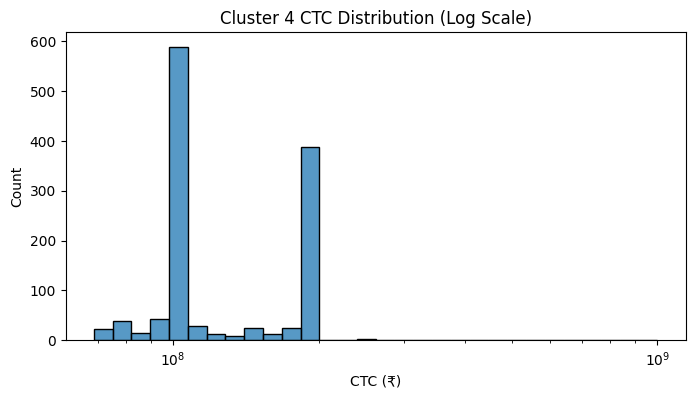

In [255]:
# Explore Cluster 4
cluster_4 = employee_df[employee_df['cluster'] == 4]

# Summary of CTC and YOE
print("Cluster 4 Summary:")
print(cluster_4[['ctc', 'yoe']].describe())

# Visualize distribution of CTC in log scale to catch variations
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.histplot(cluster_4['ctc'], log_scale=True, bins=30)
plt.title('Cluster 4 CTC Distribution (Log Scale)')
plt.xlabel('CTC (₹)')
plt.show()

In [256]:
# List extreme top CTC earners
cluster_4.sort_values('ctc', ascending=False).head(10)

,email_hash,company_hash,job_position,orgyear,ctc,ctc_updated_year,designation,class,tier,yoe,job_position_actual,cluster
25103,29a71dd13adf6d2d497571a565bb3096cf66cb46cd1ece...,29801,366,2015,1.000150e+09,2020.0,2,2,2,10.0,Other,4
54673,5b4bed51797140db4ed52018a979db1e34cee49e27b488...,14271,256,2018,2.555556e+08,2016.0,1,1,1,7.0,FullStack Engineer,4
4154,06d231f167701592a69cdd7d5c825a0f5b30f0347a4078...,1198,366,2021,2.500000e+08,2020.0,2,2,2,4.0,Other,4
89734,95c8bdd3d10f967f6bfb32f280b0b37fbf5db2359918ba...,25972,188,2016,2.000000e+08,2020.0,1,1,1,9.0,Data Analyst,4
36296,3c85c094eaeb923add569ed91b8fbd6f8d8e8194dbaff5...,25972,135,2021,2.000000e+08,2019.0,1,1,1,4.0,Backend Engineer,4
36195,3c59fb8e148f30800e07b6a993ab0606662312be8a28e8...,11289,366,2012,2.000000e+08,2020.0,2,2,2,13.0,Other,4
29717,318b9bd7c00bf13cd65c930abf7cdde60fd3173e01d242...,13421,366,2019,2.000000e+08,2020.0,2,2,2,6.0,Other,4
83345,8b48f1eb194ae0e4e7c5a0e862c1cdd36d59f5cf7bdf2e...,15349,366,2020,2.000000e+08,2019.0,1,1,1,5.0,Other,4
83274,8b2997a04a5160abf65e67f424aeeb3f53bb3244555bf6...,14370,366,2015,2.000000e+08,2020.0,2,2,2,10.0,Other,4
90801,979235a69267e855c0361f670e5941138307caf43fa986...,13323,628,2018,2.000000e+08,2020.0,1,1,1,7.0,Support Engineer,4


### 🧠 Observations

- **Cluster 4** is composed of **extremely high CTC earners**, averaging over ₹13.5 Cr.

- Positions like **Support Engineer, Data Analyst, Backend Engineer** and vague labels like **“Other”** appear frequently among high earners, suggesting:
  - Possible **CTC data entry issues**, misreporting, or compensation in **stock/options**.
  - Employees with rare roles or titles not captured in standard labels.

- Further checks are needed for **designation**, **company credibility**, and **CTC consistency**.

## ✅ Step 3: t-SNE or PCA for 2D Visualization

### PCA

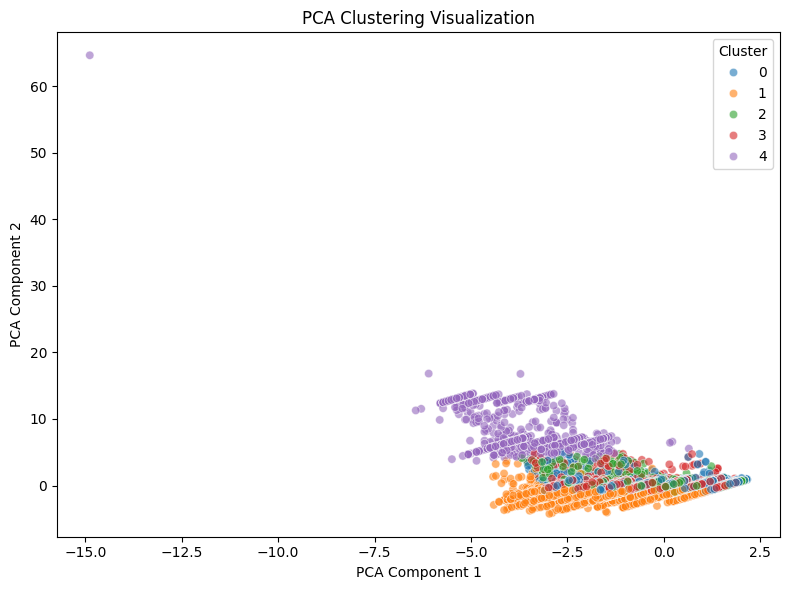

In [258]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ✅ Step 1: Select relevant features (same as used in clustering)
features = ['ctc', 'yoe', 'designation', 'class', 'tier']  # Add more if needed
X = employee_df[features]

# ✅ Step 2: Scale the features
X_scaled = StandardScaler().fit_transform(X)

# ✅ Step 3: Apply PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

# ✅ Step 4: Store PCA results
employee_df['pca_1'] = pca_result[:, 0]
employee_df['pca_2'] = pca_result[:, 1]

# ✅ Step 5: Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='cluster',
    data=employee_df,
    palette='tab10',
    alpha=0.6
)
plt.title("PCA Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [259]:
pca.explained_variance_ratio_

array([0.43939263, 0.19787537])

## PCA Clustering Summary

- **Variance Explained:**
  - PC1: `43.9%`
  - PC2: `19.8%`
  - **Total**: ~63.7% of the total variance is captured by the first two principal components, which is good for visualization.

- **Observations from the Plot:**
  - **Cluster 4** (purple) is **well-separated**, forming a distinct region in the PCA space — aligns with high CTC outliers.
  - **Clusters 0, 1, 2, and 3** overlap significantly, indicating that their CTC, YOE, and role/tier-based features have moderate distinction.
  - The distribution suggests that **most employee profiles** share overlapping characteristics, while **Cluster 4 represents a unique elite group** (possibly high-paying roles or anomalies).

- **Anomalies:**
  - A few points are far from the main cluster (e.g., extreme top left) — could be outliers or extremely high CTC roles.

- **Interpretation:**
  - PCA confirms the **existence of a distinct high-CTC cluster** (Cluster 4) and gives some shape to overlapping behavioral clusters.


### t-SNE

In [261]:
# t-sne will take super long time to run please run it if u require it only then.
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# # Select features used in clustering (replace with your final feature list)
# features = ['ctc', 'yoe', 'designation', 'class', 'tier']
# X = employee_df[features]
# X_scaled = StandardScaler().fit_transform(X)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# tsne_results = tsne.fit_transform(X_scaled)

# # Add t-SNE components to dataframe
# df['tsne_1'] = tsne_results[:, 0]
# df['tsne_2'] = tsne_results[:, 1]

# # Plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df, palette='tab10', alpha=0.6)
# plt.title("t-SNE Clustering Visualization")
# plt.show()

## ✅ Step 4: Compare Clusters with Manual Flags

In [262]:
# Mean of manual flags per cluster
manual_flag_summary = employee_df.groupby('cluster')[['designation', 'class', 'tier']].mean().reset_index()
print("Average Manual Flags per Cluster:")
display(manual_flag_summary)

Average Manual Flags per Cluster:


,cluster,designation,class,tier
0,0,2.211200,2.373568,2.468187
1,1,2.041756,1.920872,1.862020
2,2,2.188546,2.334653,2.523136
3,3,2.205486,2.353031,2.459968
4,4,1.578383,1.415842,1.309406


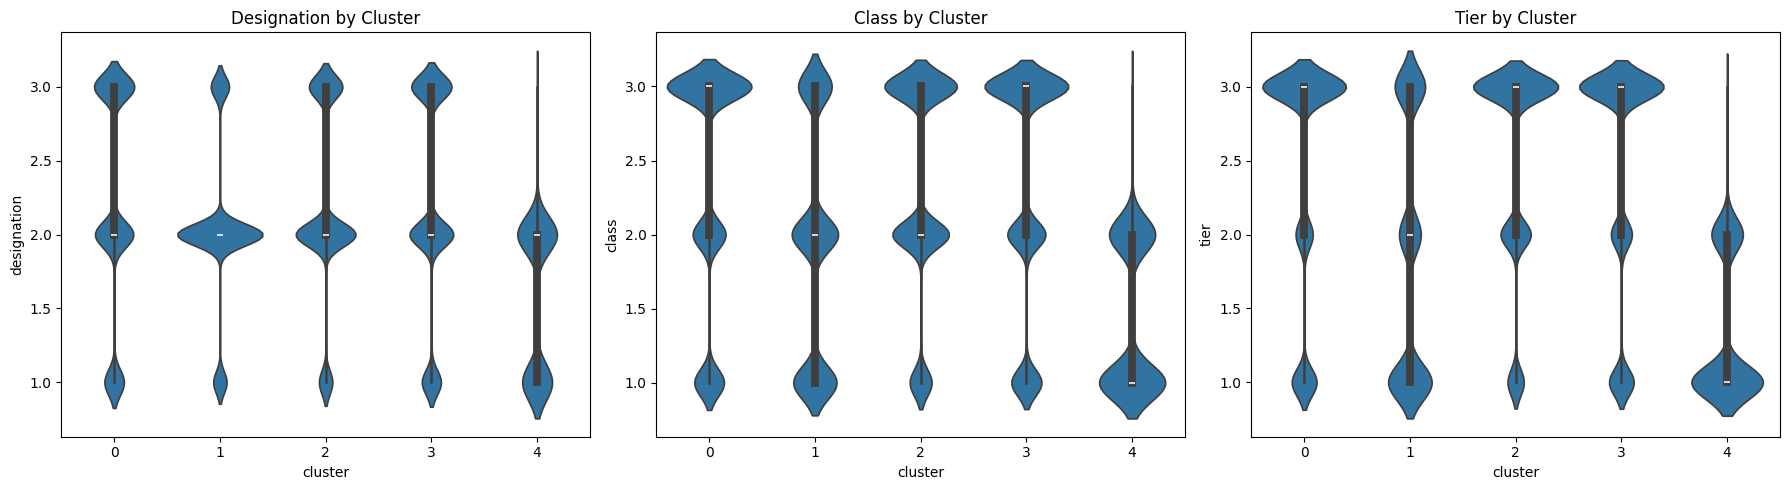

In [265]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.violinplot(x='cluster', y='designation', data=employee_df, ax=axes[0])
axes[0].set_title("Designation by Cluster")
sns.violinplot(x='cluster', y='class', data=employee_df, ax=axes[1])
axes[1].set_title("Class by Cluster")
sns.violinplot(x='cluster', y='tier', data=employee_df, ax=axes[2])
axes[2].set_title("Tier by Cluster")
plt.tight_layout()
plt.show()

## 🎻 Violin Plot Interpretation: Designation, Class, and Tier by Cluster

### ⚠️ Flag Legend (as defined):
- **1 → Above average**
- **2 → Around average**
- **3 → Below average**

These flags are derived based on:
| Flag        | Grouping Level                              | Purpose                                           |
|-------------|---------------------------------------------|---------------------------------------------------|
| designation | `company_hash`, `job_position`, `orgyear`   | Compares salary within same job & year            |
| class       | `company_hash`, `job_position`              | Compares salary within same job role              |
| tier        | `company_hash`                              | Compares salary across the company                |

---

### ✅ Designation by Cluster
- **Clusters 0, 2, 3**: High density around **designation = 2 and 3**, indicating most employees earn **around or below average** for their role, company, and year.
- **Cluster 1**: Concentrated near **designation = 2**, suggesting majority are **average earners**.
- **Cluster 4**: Skewed toward **designation = 1**, meaning employees are earning **above average** compared to their peers — likely reflecting high CTC earners.

---

### ✅ Class by Cluster
- **Clusters 0, 2, 3**: Mostly in **class = 2 or 3**, suggesting **average to below average salaries** within the same job role and company.
- **Cluster 1**: Mostly at **class = 2**, indicating **around average** earnings.
- **Cluster 4**: Strongly concentrated at **class = 1**, reflecting **above average** pay compared to peers in the same role.

---

### ✅ Tier by Cluster
- **Clusters 0–3**: Most employees fall in **tier = 2 or 3**, i.e., earning **average or below average** compared to others within the same company.
- **Cluster 4**: Dominated by **tier = 1**, showing these employees are **top earners within their companies**.

---

### 💡 Summary Insights
- **Cluster 4** is the standout group — composed of **high CTC earners** consistently performing **above average** across designation, class, and tier.
- **Clusters 0, 2, 3** are largely **average or below average** groups in salary terms across all three flags.
- **Cluster 1** shows relatively **balanced performance**, leaning toward **average** salary distributions.

# 📊 Final Insights and Recommendations

## 🧠 Business Context
As a data scientist at Scaler's analytics team, our goal was to **profile the best companies and job positions** based on the career outcomes of Scaler learners. By clustering learners using their salary (CTC), job roles, experience, and company-level performance, we aimed to identify high-value job paths and organizational patterns that differentiate top earners.

---

## 🔍 Key Insights from Clustering Analysis

### ✅ Cluster Composition
- **5 clusters** were identified using KMeans, with the number optimized using the elbow method.
- Clusters showed meaningful differences in **CTC, years of experience (YOE), job roles, and company patterns**.

### 💸 Salary Distribution (CTC)
- **Cluster 4** is the clear outlier, representing **ultra-high CTC earners** (mean CTC ~ ₹13.5 Cr, max up to ₹100 Cr+).
  - These are rare cases (~1.2k out of ~150k), likely reflecting **senior leadership, niche expertise, or global roles**.
- Clusters **0, 2, and 3** represent the **majority of learners** with CTCs in the **₹5–15 LPA** range.
- **Cluster 1** stands out with **experienced professionals** (avg YOE ~19) earning **higher-than-average salaries**.

### 👷 Job Position Patterns
- Common roles like **Backend Engineer, FullStack Engineer, Data Scientist** dominate most clusters.
- **Cluster 4** includes roles like **Research Engineers, SDET, Support Engineer**, indicating a niche mix.
- **Cluster 1** includes more **Engineering Leadership and Architect** roles, aligning with high experience.

### 🏢 Company Trends
- Certain companies (even anonymized via `company_hash`) appeared disproportionately in **Cluster 4 and 1**, suggesting they offer better pay and growth opportunities.
- Clusters with high `company_hash` frequency in top positions can be used to shortlist **high-performing organizations**.

### 📈 Manual Performance Flags
- **Designation, Class, and Tier flags** were used to compare salary within:
  - same job role/year,
  - same job role,
  - same company.
- **Cluster 4** performed **consistently above average (flag = 1)** across all three dimensions.
- Clusters 0–3 mostly fell into **average or below average** categories (flag = 2 or 3).

---

## 💡 Strategic Recommendations

### 🏆 1. Promote High-Growth Career Paths
- **Backend, FullStack, Data Scientists** show consistently high demand and salaries — focus training and placement efforts here.
- Encourage transitions into roles found in Cluster 4 (e.g., **Research Engineers**, **SDET**, **AI/ML leadership**) for learners with advanced skills.

### 🏢 2. Build Stronger Company Partnerships
- Use `company_hash` patterns to **identify top-paying companies** and prioritize them for placements, employer partnerships, and alumni spotlights.

### 🔁 3. Benchmark Performance with Flags
- Utilize the **designation, class, and tier flags** as a feedback mechanism for learners:
  - Flag = 3 → Below average: recommend skill upgradation, negotiation strategies.
  - Flag = 1 → Above average: highlight these learners as success stories.

### 📚 4. Tailor Learning Paths by Cluster
- Customize curriculum recommendations based on the **learner’s cluster profile** to improve their chances of transitioning to higher-paying roles.

### 📊 5. Monitor Outliers and Validate Data
- A few records had **unrealistic CTC values (₹100 Cr+)** — ensure validation or exclusion in future iterations to avoid skewed insights.

---

## 🧭 Conclusion

Clustering helped uncover **career patterns, salary benchmarks, and company trends** among Scaler learners. These insights can now guide **personalized career planning, targeted upskilling, and focused industry outreach**, driving better learner outcomes and business value.